1/1 [==============================] - 1s 1s/step
Predicted: [('n02391049', 'zebra', 9.567863)]


<ipython-input-12-e2a33131f796>:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


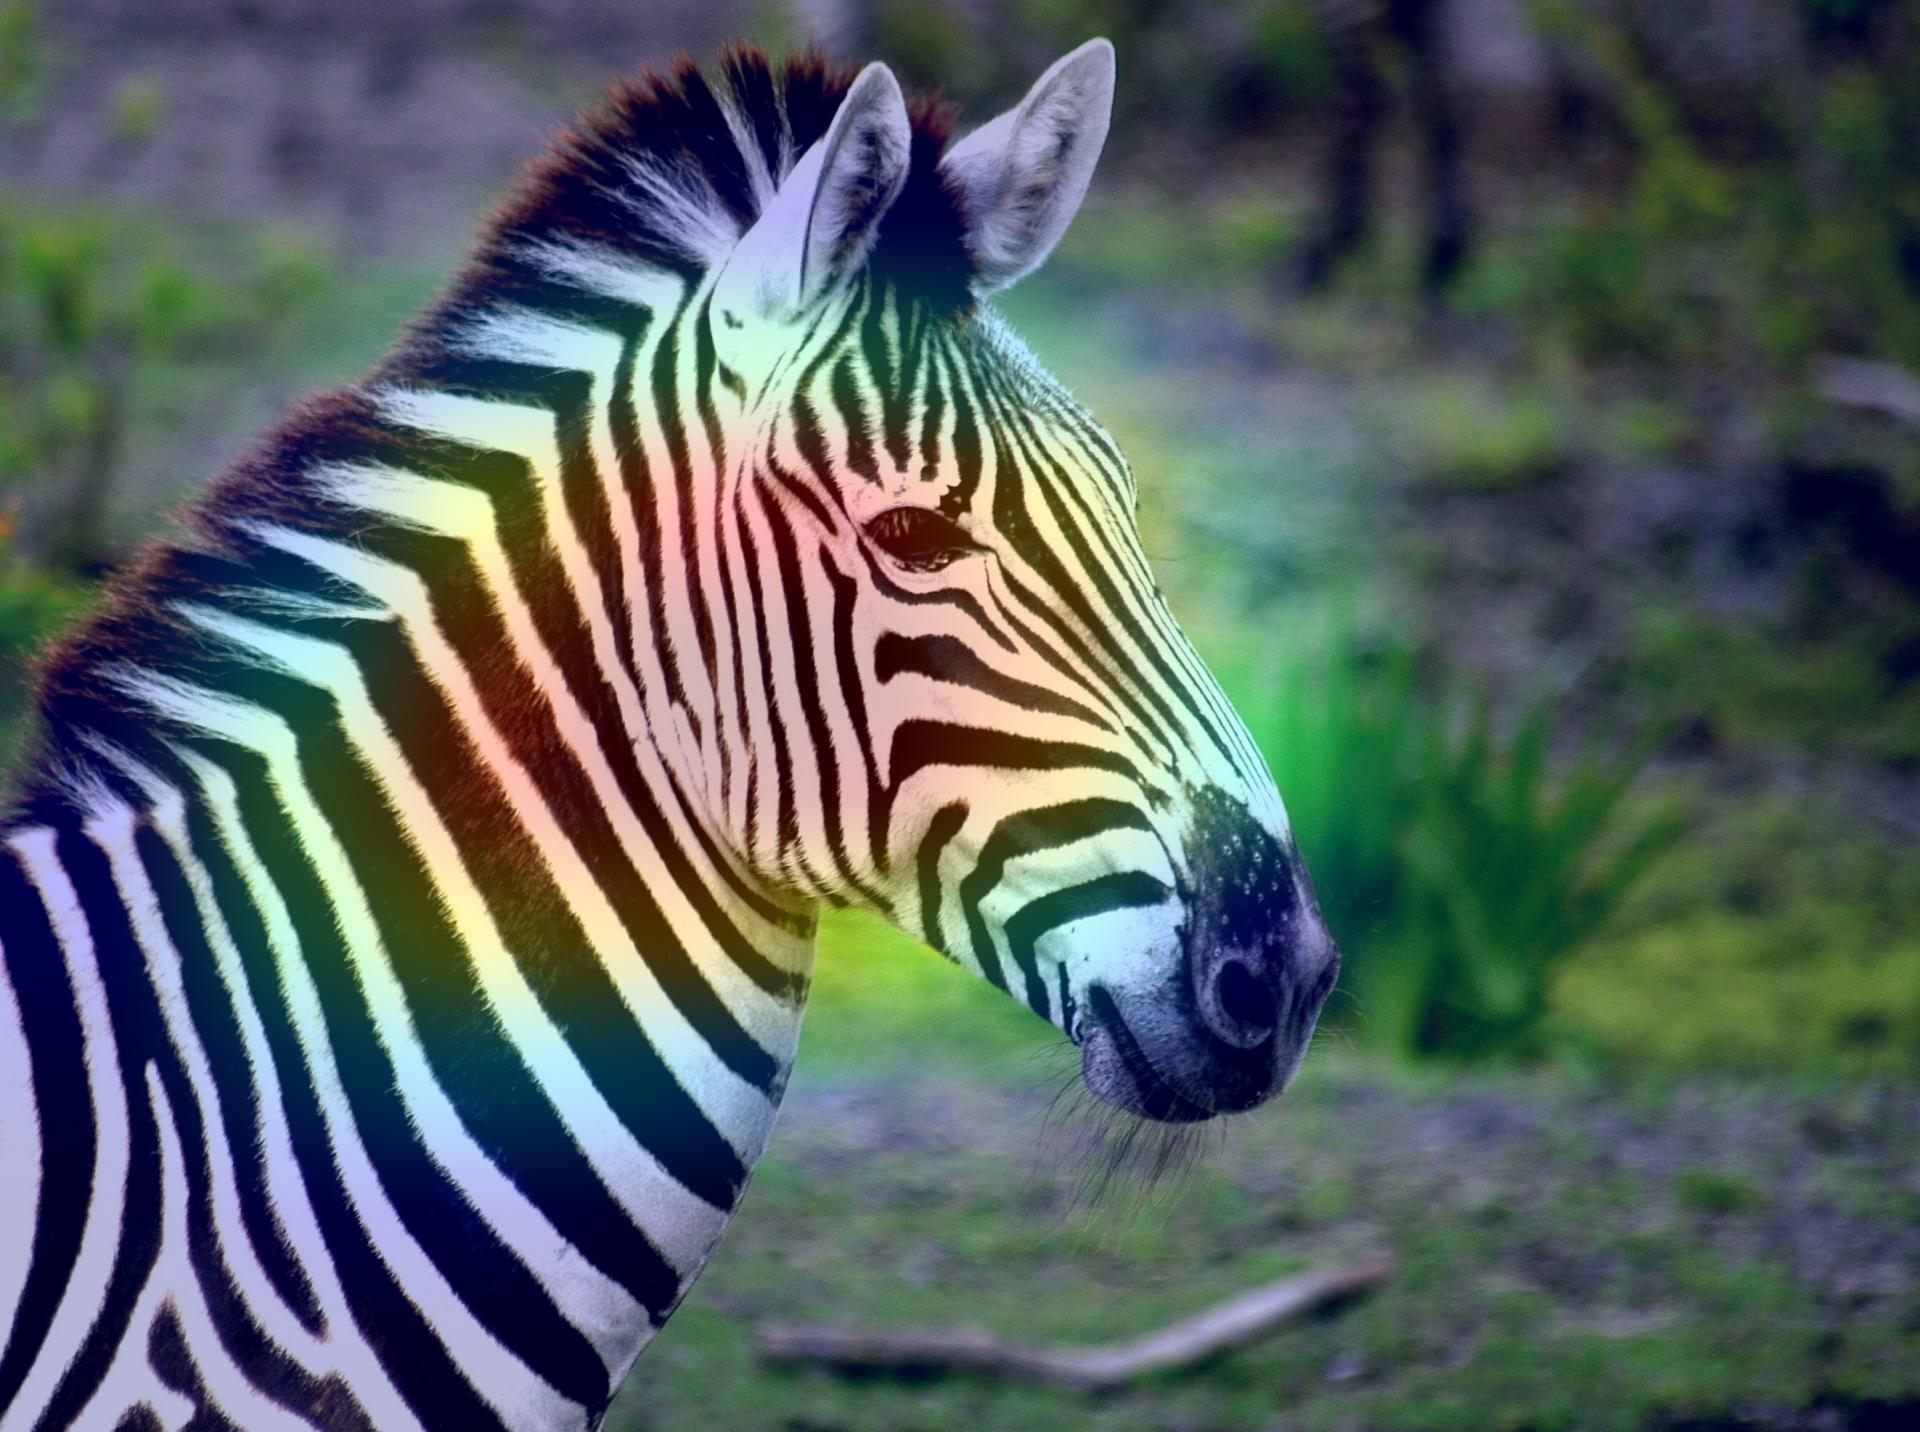

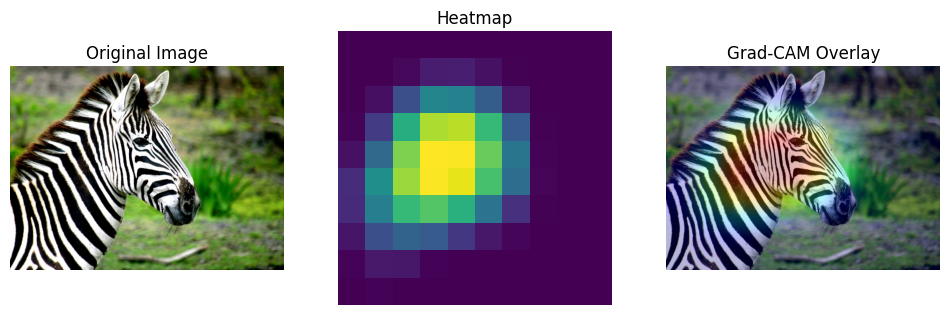

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from IPython.display import Image, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
zebra_img_path = '/content/zebra-1403093847jNA.jpg'

def load_and_preprocess_image(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def generate_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
zebra_img_array = keras.applications.xception.preprocess_input(
    load_and_preprocess_image(zebra_img_path, size=img_size)
)

# Make model
xception_model = model_builder(weights="imagenet")
xception_model.layers[-1].activation = None

# Print top predicted class
zebra_preds = xception_model.predict(zebra_img_array)
print("Predicted:", keras.applications.xception.decode_predictions(zebra_preds, top=1)[0])

# Generate class activation heatmap for the image
zebra_heatmap = generate_heatmap(zebra_img_array, xception_model, last_conv_layer_name)

# Display original image, heatmap, and Grad-CAM overlay image
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
img = image.load_img(zebra_img_path)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(zebra_heatmap, cmap='viridis')
plt.title('Heatmap')
plt.axis('off')

# Grad-CAM Overlay
plt.subplot(1, 3, 3)
overlay_path = "/content/overlay.jpg"
save_and_display_heatmap_overlay(zebra_img_path, zebra_heatmap, overlay_path)
img_overlay = image.load_img(overlay_path)
plt.imshow(img_overlay)
plt.title('Grad-CAM Overlay')
plt.axis('off')

plt.show()

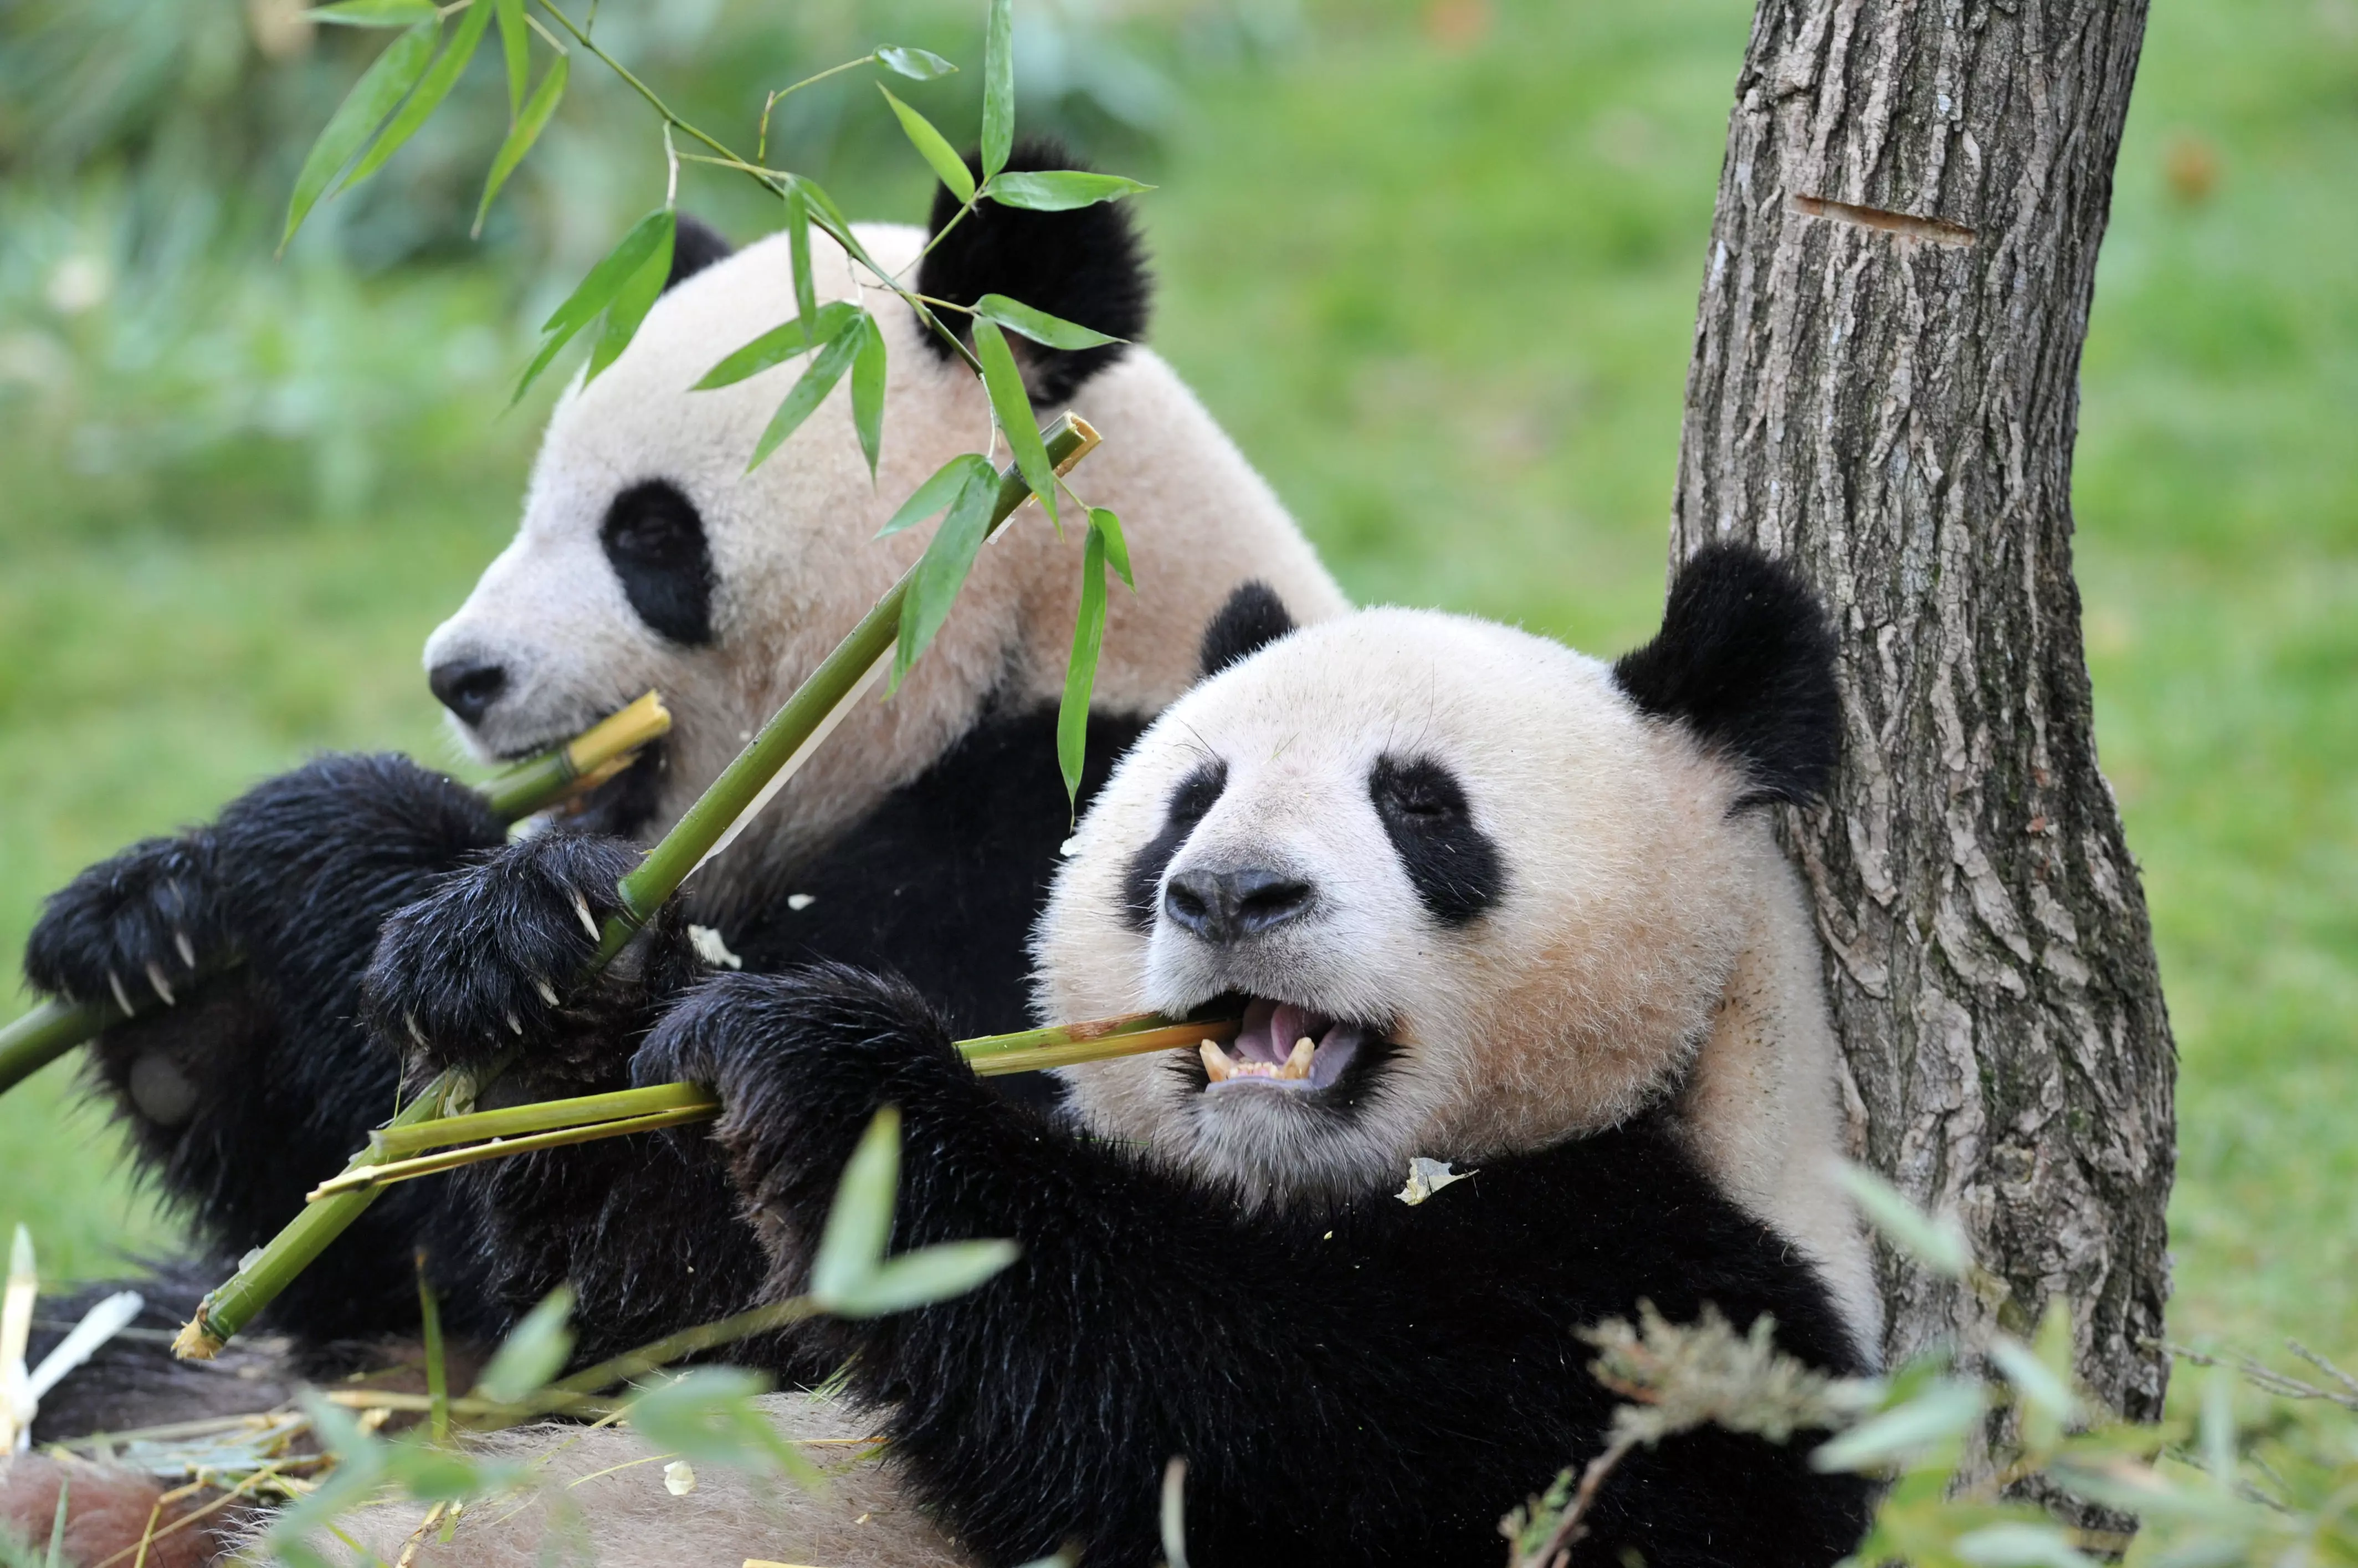

1/1 [==============================] - 1s 707ms/step
Predicted: [('n02510455', 'giant_panda', 9.410899), ('n04399382', 'teddy', 3.2694147)]


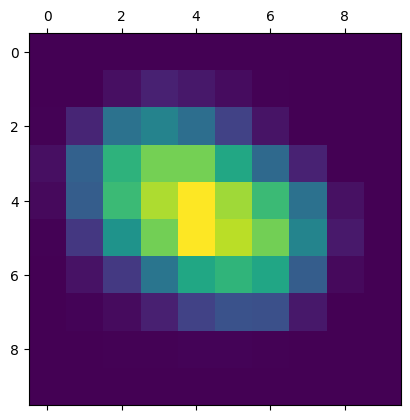

<ipython-input-6-e2a33131f796>:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


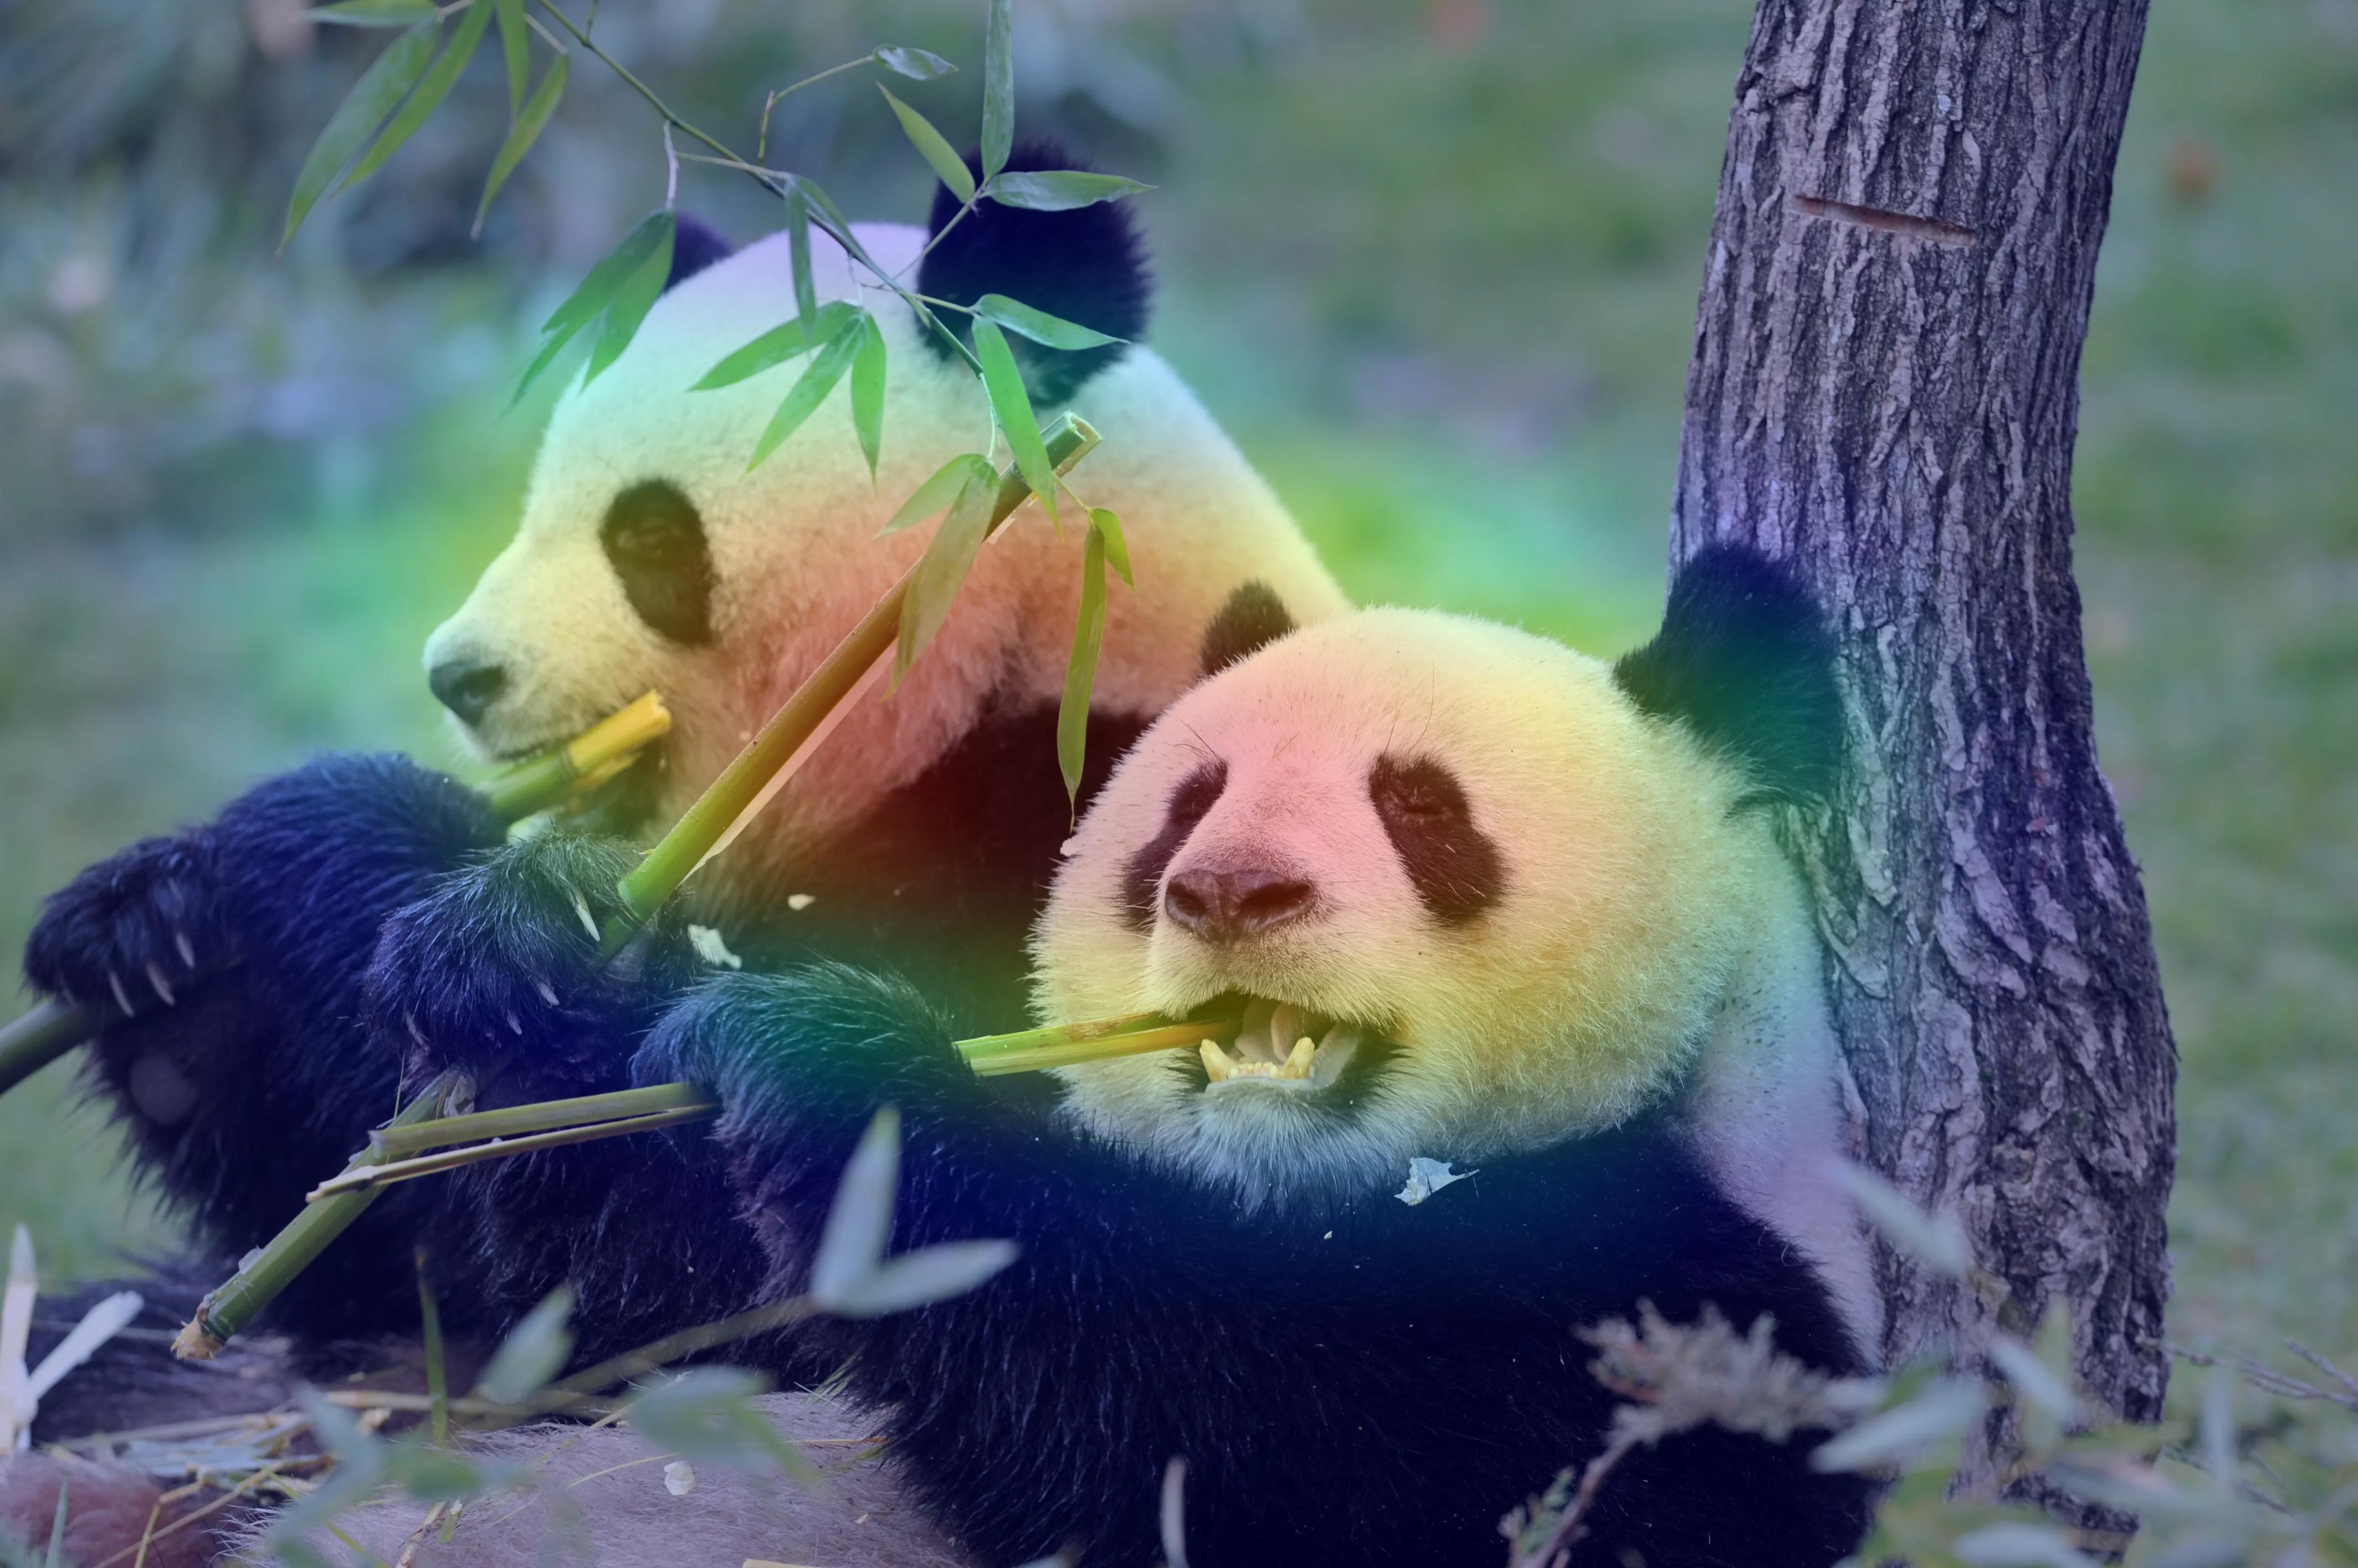

In [ ]:
# Similarly, apply Grad-CAM on another image
img_path = '/content/13_panda_267 (1).jpg'

display(Image(img_path))

# Prepare image
img_array = keras.applications.xception.preprocess_input(
    load_and_preprocess_image(img_path, size=img_size)
)

# Print top predicted classes
preds = xception_model.predict(img_array)
print("Predicted:", keras.applications.xception.decode_predictions(preds, top=2)[0])

# Generate class activation heatmap for image
heatmap = generate_heatmap(img_array, xception_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Display and save Grad-CAM overlay for image
save_and_display_heatmap_overlay(img_path, heatmap)